<a href="https://colab.research.google.com/github/joneman/weather-data-pipeline/blob/main/clean_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
# Importing necessary libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # For data visualization
# Ensures that plots are displayed inline in Jupyter Notebook
%matplotlib inline
import seaborn as sns  # For enhanced data visualization and statistical plotting

# Setting Pandas options to format float numbers to 2 decimal places
pd.options.display.float_format = '{:.2f}'.format

import os
import warnings
warnings.filterwarnings('ignore')


In [96]:
# Load the dataset from a CSV file
df = pd.read_csv('weather_data.csv')  # The name must match the uploaded file
# Display the first 5 rows of the DataFrame
df.head()

,date,city,temperature_celsius,humidity_percent,wind_speed_kph,weather_condition
0,2023-01-01,New York,5.00,60.00,10.00,Sunny
1,01/02/2023,New York,NaN,65.00,12.00,Cloudy
2,03-01-2023,New York,7.00,NaN,8.00,Rainy
3,NaN,London,8.00,70.00,15.00,Unknown
4,2023-01-02,London,6.00,75.00,20.00,Snowy


In [95]:
# Print information about the DataFrame, including column data types and non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 0 to 98
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    63 non-null     object 
 1   city                    78 non-null     object 
 2   temperature_celsius     78 non-null     float64
 3   humidity_percent        78 non-null     float64
 4   wind_speed_kph          78 non-null     float64
 5   weather_condition       78 non-null     object 
 6   temperature_fahrenheit  78 non-null     float64
dtypes: float64(4), object(3)
memory usage: 4.9+ KB


In [61]:
# Display the column names of the DataFrame
df.columns


Index(['date', 'city', 'temperature_celsius', 'humidity_percent',
       'wind_speed_kph', 'weather_condition'],
      dtype='object')

In [62]:
# Calculate and display the sum of missing values for each column
df.isnull().sum()


,0
date,20
city,0
temperature_celsius,58
humidity_percent,53
wind_speed_kph,45
weather_condition,16


In [44]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,14,2023-01-11 15:25:42.857142784,2023-01-01 00:00:00,2023-01-05 00:00:00,2023-01-09 12:00:00,2023-01-15 18:00:00,2023-01-29 00:00:00,NaN
temperature_celsius,14.00,6.96,-1.70,5.25,7.16,9.67,14.80,4.22
humidity_percent,14.00,58.79,37.00,60.00,60.00,60.00,75.00,8.01
wind_speed_kph,14.00,15.11,5.00,14.20,14.20,16.75,26.30,5.38


In [49]:
# Convert the date column to a consistent format
df['date'] = pd.to_datetime(df['date'], errors='coerce')
# Sort data by date for proper interpolation
df.sort_values(by=['city', 'date'], inplace=True)

In [53]:
# Fill missing dates using forward-fill and backward-fill
df['date'].ffill(inplace=True)
df['date'].bfill(inplace=True)

In [67]:
# Interpolate missing temperature values for smooth trends
df['temperature_celsius'] = df.groupby('city')['temperature_celsius'].apply(lambda x: x.interpolate(method='linear')).reset_index(level=0, drop=True)
# Replace missing humidity & wind speed values with the median per city
df['humidity_percent'] = df.groupby('city')['humidity_percent'].transform(lambda x: x.fillna(x.median()))
df['wind_speed_kph'] = df.groupby('city')['wind_speed_kph'].transform(lambda x: x.fillna(x.median()))



In [72]:
# Forward-fill and backward-fill missing values
df['weather_condition'] = df['weather_condition'].ffill()
df['weather_condition'] = df['weather_condition'].bfill()

# If some values are still missing, replace them with the most frequent weather condition per city
df['weather_condition'] = df.groupby('city')['weather_condition'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))


In [74]:
# Convert temperature from Celsius to Fahrenheit
df['temperature_fahrenheit'] = df['temperature_celsius'] * 9/5 + 32

# Display updated data with new column
print("Updated Data Preview:")
print(df.head())


Updated Data Preview:
         date      city  temperature_celsius  humidity_percent  \
0  2023-01-01  New York                 5.00             60.00   
1  01/02/2023  New York                 6.00             65.00   
2  03-01-2023  New York                 7.00             55.50   
3         NaN    London                 8.00             70.00   
4  2023-01-02    London                 6.00             75.00   

   wind_speed_kph weather_condition  temperature_fahrenheit  
0           10.00             Sunny                   41.00  
1           12.00            Cloudy                   42.80  
2            8.00             Rainy                   44.60  
3           15.00           Unknown                   46.40  
4           20.00             Snowy                   42.80  


In [76]:
# Remove rows where weather_condition is 'Unknown' or missing
df = df[df['weather_condition'].notna()]  # Remove NULL values
df = df[df['weather_condition'] != "Unknown"]  # Remove 'Unknown'

# Confirm filtered data
print(f"Remaining rows after filtering: {len(df)}")
print(df.head())


Remaining rows after filtering: 78
         date      city  temperature_celsius  humidity_percent  \
0  2023-01-01  New York                 5.00             60.00   
1  01/02/2023  New York                 6.00             65.00   
2  03-01-2023  New York                 7.00             55.50   
4  2023-01-02    London                 6.00             75.00   
5  01/03/2023    London                 6.65             80.00   

   wind_speed_kph weather_condition  temperature_fahrenheit  
0           10.00             Sunny                   41.00  
1           12.00            Cloudy                   42.80  
2            8.00             Rainy                   44.60  
4           20.00             Snowy                   42.80  
5           18.00            Cloudy                   43.97  


In [79]:
# Ensure the 'outputs' folder exists
os.makedirs("outputs", exist_ok=True)

# Save transformed data as CSV
df.to_csv("outputs/transformed_weather_data.csv", index=False)

print("Transformed weather data saved successfully!")


Transformed weather data saved successfully!


In [94]:
# Compute average temperature per city for all cities
avg_temp_all_cities = df.groupby('city')['temperature_celsius'].mean().sort_values(ascending=False)

# Save report as a text file
report_path = "outputs/weather_report.txt"
with open(report_path, "w") as f:
    f.write("Average Temperature per City:\n")
    f.write(str(avg_temp_all_cities))

print("Weather report with all cities generated successfully!")


Weather report with all cities generated successfully!


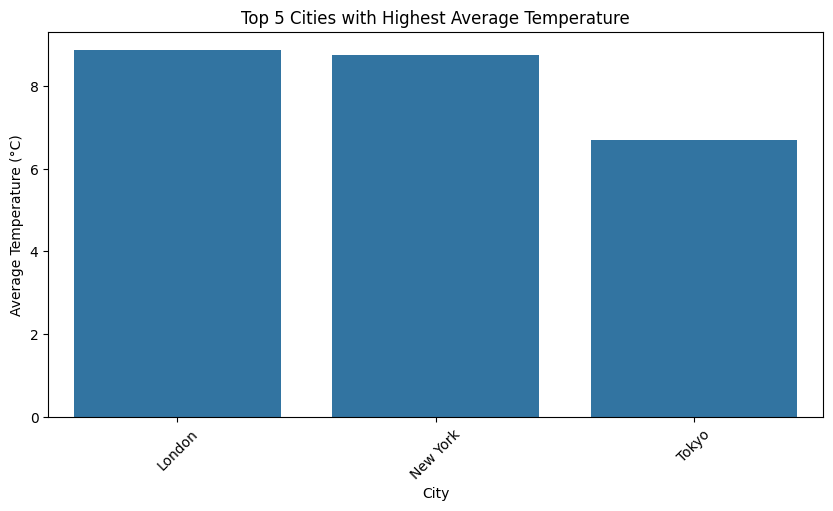

In [84]:
plt.figure(figsize=(10,5))
sns.barplot(x=top_cities.index, y=top_cities.values)
plt.title("Top 5 Cities with Highest Average Temperature")
plt.xlabel("City")
plt.ylabel("Average Temperature (°C)")
plt.xticks(rotation=45)
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

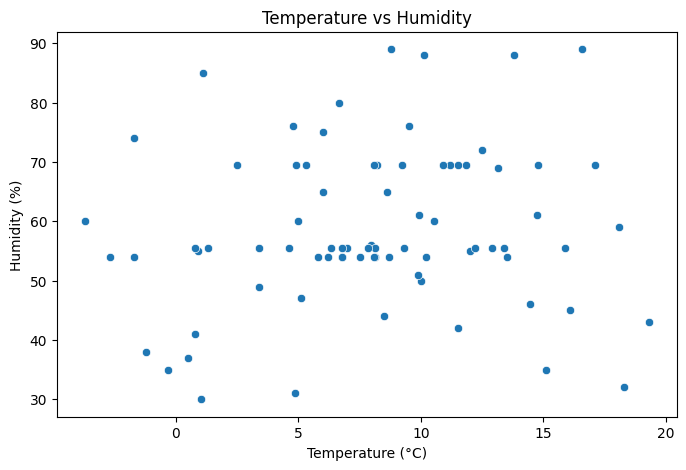

In [86]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['temperature_celsius'], y=df['humidity_percent'])
plt.title("Temperature vs Humidity")
plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")
plt.show()


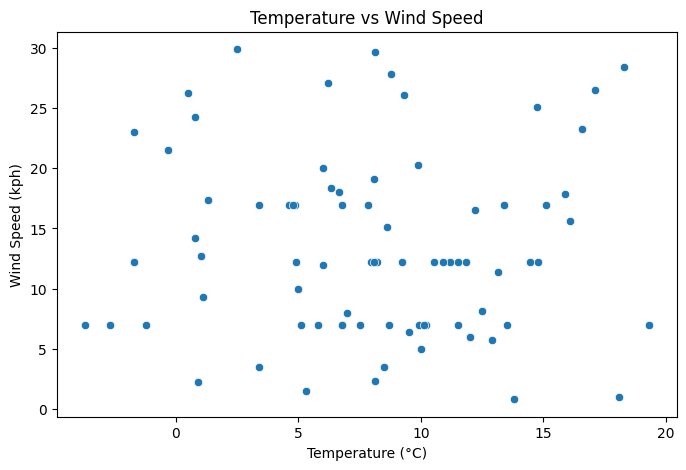

In [88]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['temperature_celsius'], y=df['wind_speed_kph'])
plt.title("Temperature vs Wind Speed")
plt.xlabel("Temperature (°C)")
plt.ylabel("Wind Speed (kph)")
plt.show()



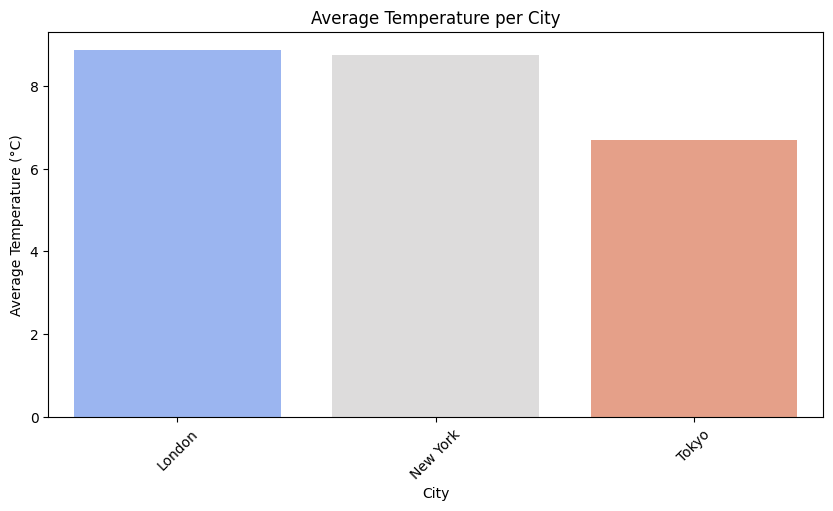

In [93]:
# Compute average temperature per city
avg_temp = df.groupby("city")["temperature_celsius"].mean()

# Create the bar chart
plt.figure(figsize=(10,5))
sns.barplot(x=avg_temp.index, y=avg_temp.values, palette="coolwarm")

# Add labels and title
plt.title("Average Temperature per City")
plt.xlabel("City")
plt.ylabel("Average Temperature (°C)")
plt.xticks(rotation=45)

# Save the figure
plt.savefig("outputs/average_temperature_chart.png")
plt.show()
